# Task VIII: Vision transformer/Quantum Vision Transformer

Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.

In [1]:
from IPython.display import clear_output
!pip install torchmetrics
clear_output()

In [2]:
# Imports
import math
import numpy as np
from timeit import default_timer as timer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange
from torchmetrics import AUROC

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

In [3]:
torch.__version__

'2.2.1+cu121'

In [4]:
np.random.seed(2024)
torch.manual_seed(2024)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Hyperparameters:
config={}
config["image_height"] = 28
config["image_width"] = 28
config["num_channels"] = 1
config["patch_height"] = 4
config["patch_width"] = 4
config["hidden_dim"] = 128
config["pos_enc_dim"] = 1
config["num_heads"] = 6
config["hidden_drp_prob"] = 0.15
config["qkv_bias"] = True
config["intermediate_size"] = 64
config["num_encoder_blocks"] = 6
config["output_dim"] = 10
config["batch_size"] = 128

In [6]:
# Loading the data to the dataloaders:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

train_set = MNIST(
        root="./../datasets", train=True, download=True, transform=data_transforms,target_transform=lambda y: F.one_hot(torch.tensor(y), 10).to(torch.float32)
    )
test_set = MNIST(
        root="./../datasets", train=False, download=True, transform=data_transforms,target_transform=lambda y: F.one_hot(torch.tensor(y), 10).to(torch.float32)
    )

train_set,val_set = torch.utils.data.random_split(train_set,[.8,.2])

train_loader = DataLoader(train_set, shuffle=True, batch_size=config["batch_size"])
val_loader = DataLoader(val_set, shuffle=False, batch_size=config["batch_size"])
test_loader = DataLoader(test_set, shuffle=False, batch_size=config["batch_size"])

100%|██████████| 9912422/9912422 [00:00<00:00, 103635625.73it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105427061.64it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29985004.65it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22307410.74it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



In [7]:
# Building the model:
class PatchEmbedding1D(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.image_height = config["image_height"]
        self.image_width = config["image_width"]
        self.num_channels = config["num_channels"]

        self.patch_height = config["patch_height"]
        self.patch_width = config["patch_width"]

        self.hidden_size = config["hidden_dim"]
        self.num_patches = (self.image_height//self.patch_height)*(self.image_width//self.patch_width)
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=(self.patch_height, self.patch_width), stride=(self.patch_height, self.patch_width))

    def forward(self, images):
        return self.projection(images).flatten(2)

def get_emb(sin_inp):
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.register_buffer("cached_penc", None, persistent=False)

    def forward(self, tensor):
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device, dtype=self.inv_freq.dtype)
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device, dtype=tensor.dtype)
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc


class PositionalEncodingPermute1D(nn.Module):
    def __init__(self, channels):
        super(PositionalEncodingPermute1D, self).__init__()
        self.penc = PositionalEncoding1D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 2, 1)

    @property
    def org_channels(self):
        return self.penc.org_channels

class PosEmbed(nn.Module):
    def __init__(self, config):
        super(PosEmbed, self).__init__()
        self.config = config

        if self.config["pos_enc_dim"] == 1:
            self.posenc = PositionalEncodingPermute1D(self.config["hidden_dim"])
            self.paenc = PatchEmbedding1D(self.config)

    def forward(self, image_tensor):
        """
        Takes the image tensor and returns the positonally embedded tensor
        """
        embed_patch_tensor = self.paenc(image_tensor)
        posenc = self.posenc(embed_patch_tensor)

        assert (
            embed_patch_tensor.size() == posenc.size()
        ), "The original tensor size {} and the positional encoding tensor size {} must match!".format(
            embed_patch_tensor.size(), posenc.size()
        )
        return torch.flatten(embed_patch_tensor + posenc,2).transpose(1, 2)


class AttentionHead(nn.Module):
    def __init__(self,config):
        """
        Calculates the Attention values
        """
        super(AttentionHead,self).__init__()

        self.config = config
        self.hidden_dim = self.config["hidden_dim"]
        self.num_heads = self.config["num_heads"]
        self.attention_head_size = self.hidden_dim // self.num_heads

        self.Q = nn.Linear(self.hidden_dim, self.attention_head_size, bias=self.config["qkv_bias"])
        self.K = nn.Linear(self.hidden_dim, self.attention_head_size, bias=self.config["qkv_bias"])
        self.V = nn.Linear(self.hidden_dim, self.attention_head_size, bias=self.config["qkv_bias"])


    def forward(self,x):
        """
        x.shape = (batch_size,num_patches,hidden_dim)
        attention_head.shape = (batch_size,num_patches,attention_head_size)
        """
        attention_head = torch.matmul(nn.functional.softmax(torch.matmul(self.Q(x), self.K(x).transpose(-1, -2))/math.sqrt(self.attention_head_size), dim=-1),self.V(x))
        return attention_head


class MultiHeadAttention(nn.Module):
    """
    Calculates the Multi-head attention values
    """
    def __init__(self, config):
        super(MultiHeadAttention,self).__init__()
        self.config = config
        self.hidden_dim = self.config["hidden_dim"]
        self.num_heads = self.config["num_heads"]

        self.attention_head_size = self.hidden_dim // self.num_heads
        self.all_head_size = self.num_heads * self.attention_head_size # Won't equal hidden dim if it ain't divisible by num heads

        self.heads = nn.ModuleList([AttentionHead(self.config) for i in range(self.num_heads)])
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_dim)
        self.output_dropout = nn.Dropout(self.config["hidden_drp_prob"])

    def forward(self, x):
        """
        x.shape = (batch_size,num_patches,hidden_dim)
        output_shape = (batch_size,num_patches,hidden_dim)
        """
        attention_heads = [head(x) for head in self.heads]
        return self.output_dropout(self.output_projection(torch.cat([head for head in attention_heads], dim=-1)))



class GELU(nn.Module):
    """
    Adopted from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class FullyConnected(nn.Module):
    """
    Fully connected block consists of two linear layers
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_dim"], config["intermediate_size"])
        self.activation = GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_dim"])
        self.dropout = nn.Dropout(config["hidden_drp_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    """
    A single encoder block.
    """

    def __init__(self, config):
        super().__init__()

        self.attention = MultiHeadAttention(config)
        self.layernorm = nn.LayerNorm(config["hidden_dim"])
        self.fullyconnected = FullyConnected(config)


    def forward(self, x):
        # Attention block
        attn = self.attention(self.layernorm(x))
        x = x + attn

        # Fully Connected block
        fc = self.fullyconnected(self.layernorm(x))
        x = x + fc

        return x

class ViTEncoder(nn.Module):
    """
    The transformer encoder module.
    """
    def __init__(self, config):
        super().__init__()
        self.encoderblocks = nn.ModuleList([EncoderBlock(config) for i in range(config["num_encoder_blocks"])])

    def forward(self, x, output_attentions=False):
        for encoderblock in self.encoderblocks:
            x = encoderblock(x)
        return x


class ViT(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = PosEmbed(config)
        self.encoder = ViTEncoder(config)
        self.layernorm = nn.LayerNorm(config["hidden_dim"])
        self.outputlayer = nn.Linear(self.config["hidden_dim"], self.config["output_dim"])

    def forward(self, x):
        """Global Average Pooling is used before sending it to the final dense layer"""
        return self.outputlayer(torch.mean(self.layernorm(self.encoder(self.embedding(x))),1))

In [12]:
torch.manual_seed(42)
model = ViT(config).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=1e-3,steps_per_epoch=len(train_loader), epochs=100)
loss_fn = CrossEntropyLoss()

train_time_start_on_cpu = timer()
epochs = 100

best_val_acc = 90.
patience = 300
counter = 0
auc_metric_train = AUROC(task="multiclass",num_classes=10)
auc_metric_val = AUROC(task="multiclass",num_classes=10)
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []
history_train_auc =[]
history_val_auc = []
for epoch in trange(epochs, desc="Training"):
    ### Training
    train_loss = 0
    correct, total = 0,0
    model.train()
    auc_metric_train.reset()
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach().cpu().item()
        correct += torch.sum(torch.argmax(y_pred, dim=1) == torch.argmax(y, dim=1)).detach().cpu().item()
        total += len(x)
        auc_metric_train.update(torch.softmax(y_pred, dim=1), torch.argmax(y, dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    train_loss /= len(train_loader)
    train_acc = correct / total * 100
    train_auc = auc_metric_train.compute().detach().cpu().item()
    history_train_loss.append(train_loss)
    history_train_acc.append(train_acc)
    history_train_auc.append(train_auc)

    ### Testing
    val_loss = 0
    correct, total = 0,0
    model.eval()
    auc_metric_val.reset()
    with torch.inference_mode():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            val_pred = model(x)
            loss = loss_fn(val_pred, y)
            val_loss += loss.detach().cpu().item()
            correct += torch.sum(torch.argmax(val_pred, dim=1) == torch.argmax(y, dim=1)).detach().cpu().item()
            total += len(x)
            auc_metric_val.update(torch.softmax(val_pred, dim=1), torch.argmax(y, dim=1))

        val_loss /= len(val_loader)
        val_acc = correct / total * 100
        val_auc = auc_metric_val.compute().detach().cpu().item()
        history_val_loss.append(val_loss)
        history_val_acc.append(val_acc)
        history_val_auc.append(val_auc)


        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'ViT_mnist_model.pth')
            print("\nSaving Best Model...........")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1} as validation accuracy did not increase for {patience} epochs.')
                break


    print(f"\nEpoch: {epoch+1} | lr: {scheduler.optimizer.param_groups[0]['lr']} | train loss: {train_loss:.5f} | val loss: {val_loss:.5f} | train acc.: {train_acc:.5f}% | val acc.: {val_acc:.5f}% | train auc: {train_auc:.5f} | val auc: {val_auc:.5f}")
    print("                            ")

# Calculate training time
train_time_end_on_cpu = timer()
print(f"Time for training: {train_time_end_on_cpu - train_time_start_on_cpu}s")

Training:   1%|          | 1/100 [00:35<58:04, 35.19s/it]


Epoch: 1 | lr: 4.2629957323088506e-05 | train loss: 1.97572 | val loss: 1.33945 | train acc.: 29.14375% | val acc.: 53.85833% | train auc: 0.72982 | val auc: 0.90100
                            


Training:   2%|▏         | 2/100 [01:11<58:22, 35.74s/it]


Epoch: 2 | lr: 5.0491009811015446e-05 | train loss: 1.01974 | val loss: 0.69456 | train acc.: 68.74375% | val acc.: 79.66667% | train auc: 0.93922 | val auc: 0.96952
                            


Training:   3%|▎         | 3/100 [01:46<57:43, 35.71s/it]


Epoch: 3 | lr: 6.349701482812325e-05 | train loss: 0.55624 | val loss: 0.39967 | train acc.: 84.08125% | val acc.: 88.05000% | train auc: 0.98020 | val auc: 0.98896
                            


Training:   4%|▍         | 4/100 [02:22<57:05, 35.68s/it]


Saving Best Model...........

Epoch: 4 | lr: 8.150545054883332e-05 | train loss: 0.34892 | val loss: 0.26743 | train acc.: 89.98333% | val acc.: 92.12500% | train auc: 0.99138 | val auc: 0.99422
                            


Training:   5%|▌         | 5/100 [02:57<55:57, 35.34s/it]


Saving Best Model...........

Epoch: 5 | lr: 0.00010431897773397457 | train loss: 0.26231 | val loss: 0.21604 | train acc.: 92.15625% | val acc.: 93.69167% | train auc: 0.99473 | val auc: 0.99632
                            


Training:   6%|▌         | 6/100 [03:31<54:40, 34.90s/it]


Saving Best Model...........

Epoch: 6 | lr: 0.00013168760220485522 | train loss: 0.22459 | val loss: 0.18771 | train acc.: 93.27708% | val acc.: 94.35000% | train auc: 0.99603 | val auc: 0.99737
                            


Training:   7%|▋         | 7/100 [04:05<53:48, 34.71s/it]


Epoch: 7 | lr: 0.00016331141431835 | train loss: 0.19055 | val loss: 0.20525 | train acc.: 94.21042% | val acc.: 93.68333% | train auc: 0.99713 | val auc: 0.99727
                            


Training:   8%|▊         | 8/100 [04:40<53:10, 34.68s/it]


Saving Best Model...........

Epoch: 8 | lr: 0.00019884387542340952 | train loss: 0.16669 | val loss: 0.17326 | train acc.: 94.92917% | val acc.: 94.88333% | train auc: 0.99772 | val auc: 0.99796
                            


Training:   9%|▉         | 9/100 [05:14<52:32, 34.64s/it]


Saving Best Model...........

Epoch: 9 | lr: 0.00023789561528548978 | train loss: 0.14420 | val loss: 0.12660 | train acc.: 95.55833% | val acc.: 96.11667% | train auc: 0.99828 | val auc: 0.99884
                            


Training:  10%|█         | 10/100 [05:49<51:57, 34.64s/it]


Saving Best Model...........

Epoch: 10 | lr: 0.0002800386988661336 | train loss: 0.12637 | val loss: 0.10869 | train acc.: 96.06875% | val acc.: 96.84167% | train auc: 0.99866 | val auc: 0.99908
                            


Training:  11%|█         | 11/100 [06:24<51:19, 34.60s/it]


Epoch: 11 | lr: 0.00032481131570167264 | train loss: 0.11701 | val loss: 0.11847 | train acc.: 96.35833% | val acc.: 96.49167% | train auc: 0.99886 | val auc: 0.99913
                            


Training:  12%|█▏        | 12/100 [06:58<50:53, 34.70s/it]


Epoch: 12 | lr: 0.0003717228404941051 | train loss: 0.10336 | val loss: 0.11989 | train acc.: 96.75625% | val acc.: 96.55000% | train auc: 0.99908 | val auc: 0.99907
                            


Training:  13%|█▎        | 13/100 [07:33<50:17, 34.68s/it]


Epoch: 13 | lr: 0.00042025920945940954 | train loss: 0.09416 | val loss: 0.13725 | train acc.: 97.05208% | val acc.: 95.98333% | train auc: 0.99927 | val auc: 0.99892
                            


Training:  14%|█▍        | 14/100 [08:08<49:43, 34.69s/it]


Epoch: 14 | lr: 0.0004698885535184342 | train loss: 0.08751 | val loss: 0.11795 | train acc.: 97.25625% | val acc.: 96.49167% | train auc: 0.99933 | val auc: 0.99911
                            


Training:  15%|█▌        | 15/100 [08:42<49:08, 34.69s/it]


Saving Best Model...........

Epoch: 15 | lr: 0.0005200670266009789 | train loss: 0.08182 | val loss: 0.09584 | train acc.: 97.37083% | val acc.: 97.25833% | train auc: 0.99942 | val auc: 0.99930
                            


Training:  16%|█▌        | 16/100 [09:17<48:31, 34.66s/it]


Saving Best Model...........

Epoch: 16 | lr: 0.0005702447651956063 | train loss: 0.07821 | val loss: 0.09653 | train acc.: 97.53542% | val acc.: 97.29167% | train auc: 0.99950 | val auc: 0.99927
                            


Training:  17%|█▋        | 17/100 [09:52<47:56, 34.65s/it]


Epoch: 17 | lr: 0.0006198719138395129 | train loss: 0.07280 | val loss: 0.10731 | train acc.: 97.70417% | val acc.: 96.95833% | train auc: 0.99951 | val auc: 0.99919
                            


Training:  18%|█▊        | 18/100 [10:26<47:17, 34.60s/it]


Saving Best Model...........

Epoch: 18 | lr: 0.0006684046505201981 | train loss: 0.06909 | val loss: 0.08924 | train acc.: 97.78333% | val acc.: 97.30833% | train auc: 0.99956 | val auc: 0.99937
                            


Training:  19%|█▉        | 19/100 [11:01<46:43, 34.61s/it]


Saving Best Model...........

Epoch: 19 | lr: 0.0007153111459616503 | train loss: 0.06630 | val loss: 0.09222 | train acc.: 97.90417% | val acc.: 97.50000% | train auc: 0.99960 | val auc: 0.99931
                            


Training:  20%|██        | 20/100 [11:36<46:13, 34.67s/it]


Epoch: 20 | lr: 0.0007600773914922578 | train loss: 0.06523 | val loss: 0.09390 | train acc.: 97.91250% | val acc.: 97.49167% | train auc: 0.99966 | val auc: 0.99940
                            


Training:  21%|██        | 21/100 [12:11<45:44, 34.74s/it]


Saving Best Model...........

Epoch: 21 | lr: 0.0008022128316317693 | train loss: 0.06382 | val loss: 0.09085 | train acc.: 97.92917% | val acc.: 97.55833% | train auc: 0.99964 | val auc: 0.99928
                            


Training:  22%|██▏       | 22/100 [12:45<45:06, 34.70s/it]


Epoch: 22 | lr: 0.0008412557396745328 | train loss: 0.06278 | val loss: 0.09401 | train acc.: 97.96458% | val acc.: 97.41667% | train auc: 0.99967 | val auc: 0.99933
                            


Training:  23%|██▎       | 23/100 [13:20<44:32, 34.70s/it]


Epoch: 23 | lr: 0.0008767782773625413 | train loss: 0.06050 | val loss: 0.10063 | train acc.: 98.08125% | val acc.: 97.15000% | train auc: 0.99967 | val auc: 0.99939
                            


Training:  24%|██▍       | 24/100 [13:55<44:01, 34.76s/it]


Epoch: 24 | lr: 0.0009083911832035976 | train loss: 0.05932 | val loss: 0.09624 | train acc.: 98.09375% | val acc.: 97.23333% | train auc: 0.99968 | val auc: 0.99937
                            


Training:  25%|██▌       | 25/100 [14:29<43:16, 34.62s/it]


Saving Best Model...........

Epoch: 25 | lr: 0.0009357480380592816 | train loss: 0.06007 | val loss: 0.07457 | train acc.: 98.03958% | val acc.: 97.78333% | train auc: 0.99969 | val auc: 0.99953
                            


Training:  26%|██▌       | 26/100 [15:06<43:22, 35.17s/it]


Epoch: 26 | lr: 0.0009585490612597419 | train loss: 0.05049 | val loss: 0.08359 | train acc.: 98.37917% | val acc.: 97.71667% | train auc: 0.99978 | val auc: 0.99939
                            


Training:  27%|██▋       | 27/100 [15:41<42:50, 35.21s/it]


Epoch: 27 | lr: 0.0009765443956468954 | train loss: 0.05577 | val loss: 0.08780 | train acc.: 98.18542% | val acc.: 97.55000% | train auc: 0.99974 | val auc: 0.99939
                            


Training:  28%|██▊       | 28/100 [16:16<42:22, 35.32s/it]


Saving Best Model...........

Epoch: 28 | lr: 0.0009895368455480216 | train loss: 0.05143 | val loss: 0.07238 | train acc.: 98.35417% | val acc.: 98.05000% | train auc: 0.99978 | val auc: 0.99964
                            


Training:  29%|██▉       | 29/100 [16:52<41:57, 35.46s/it]


Epoch: 29 | lr: 0.0009973840376766108 | train loss: 0.04857 | val loss: 0.09348 | train acc.: 98.45833% | val acc.: 97.40000% | train auc: 0.99979 | val auc: 0.99944
                            


Training:  30%|███       | 30/100 [17:28<41:28, 35.55s/it]


Saving Best Model...........

Epoch: 30 | lr: 0.0009999999964192055 | train loss: 0.05017 | val loss: 0.07234 | train acc.: 98.37708% | val acc.: 98.08333% | train auc: 0.99978 | val auc: 0.99959
                            


Training:  31%|███       | 31/100 [18:03<40:51, 35.53s/it]


Epoch: 31 | lr: 0.0009994938470129105 | train loss: 0.04295 | val loss: 0.07867 | train acc.: 98.60000% | val acc.: 97.84167% | train auc: 0.99984 | val auc: 0.99955
                            


Training:  32%|███▏      | 32/100 [18:39<40:11, 35.47s/it]


Epoch: 32 | lr: 0.0009979817875004197 | train loss: 0.04575 | val loss: 0.08052 | train acc.: 98.47292% | val acc.: 97.70833% | train auc: 0.99983 | val auc: 0.99953
                            


Training:  33%|███▎      | 33/100 [19:14<39:35, 35.45s/it]


Epoch: 33 | lr: 0.0009954668629683625 | train loss: 0.03970 | val loss: 0.09416 | train acc.: 98.64167% | val acc.: 97.43333% | train auc: 0.99986 | val auc: 0.99952
                            


Training:  34%|███▍      | 34/100 [19:49<38:53, 35.36s/it]


Epoch: 34 | lr: 0.0009919541381400538 | train loss: 0.03955 | val loss: 0.08192 | train acc.: 98.71250% | val acc.: 97.77500% | train auc: 0.99986 | val auc: 0.99956
                            


Training:  35%|███▌      | 35/100 [20:25<38:17, 35.35s/it]


Saving Best Model...........

Epoch: 35 | lr: 0.000987450687175815 | train loss: 0.03625 | val loss: 0.06788 | train acc.: 98.74375% | val acc.: 98.25833% | train auc: 0.99989 | val auc: 0.99958
                            


Training:  36%|███▌      | 36/100 [21:00<37:40, 35.33s/it]


Epoch: 36 | lr: 0.000981965579426557 | train loss: 0.03581 | val loss: 0.07428 | train acc.: 98.79792% | val acc.: 97.98333% | train auc: 0.99989 | val auc: 0.99962
                            


Training:  37%|███▋      | 37/100 [21:35<37:04, 35.30s/it]


Epoch: 37 | lr: 0.0009755098611693142 | train loss: 0.03174 | val loss: 0.06655 | train acc.: 98.91875% | val acc.: 98.05833% | train auc: 0.99991 | val auc: 0.99971
                            


Training:  38%|███▊      | 38/100 [22:11<36:45, 35.57s/it]


Epoch: 38 | lr: 0.0009680965333615132 | train loss: 0.03132 | val loss: 0.06661 | train acc.: 98.97292% | val acc.: 98.20000% | train auc: 0.99991 | val auc: 0.99967
                            


Training:  39%|███▉      | 39/100 [22:47<36:07, 35.54s/it]


Epoch: 39 | lr: 0.0009597405254587729 | train loss: 0.03001 | val loss: 0.06881 | train acc.: 98.97292% | val acc.: 98.15000% | train auc: 0.99993 | val auc: 0.99974
                            


Training:  40%|████      | 40/100 [23:23<35:35, 35.58s/it]


Epoch: 40 | lr: 0.0009504586653489707 | train loss: 0.02831 | val loss: 0.07327 | train acc.: 99.07083% | val acc.: 98.12500% | train auc: 0.99994 | val auc: 0.99968
                            


Training:  41%|████      | 41/100 [23:58<35:01, 35.62s/it]


Epoch: 41 | lr: 0.0009402696454631131 | train loss: 0.02858 | val loss: 0.07294 | train acc.: 99.00625% | val acc.: 98.15833% | train auc: 0.99993 | val auc: 0.99970
                            


Training:  42%|████▏     | 42/100 [24:37<35:20, 36.56s/it]


Epoch: 42 | lr: 0.0009291939851312684 | train loss: 0.02944 | val loss: 0.07607 | train acc.: 98.97917% | val acc.: 98.25000% | train auc: 0.99993 | val auc: 0.99958
                            


Training:  43%|████▎     | 43/100 [25:15<35:16, 37.13s/it]


Epoch: 43 | lr: 0.0009172539892593674 | train loss: 0.02216 | val loss: 0.07698 | train acc.: 99.25000% | val acc.: 98.04167% | train auc: 0.99995 | val auc: 0.99967
                            


Training:  44%|████▍     | 44/100 [25:54<34:56, 37.44s/it]


Epoch: 44 | lr: 0.0009044737034100898 | train loss: 0.02667 | val loss: 0.07796 | train acc.: 99.08750% | val acc.: 98.05833% | train auc: 0.99994 | val auc: 0.99965
                            


Training:  45%|████▌     | 45/100 [26:32<34:28, 37.60s/it]


Saving Best Model...........

Epoch: 45 | lr: 0.000890878865378302 | train loss: 0.02359 | val loss: 0.06515 | train acc.: 99.17500% | val acc.: 98.39167% | train auc: 0.99996 | val auc: 0.99970
                            


Training:  46%|████▌     | 46/100 [27:08<33:24, 37.12s/it]


Epoch: 46 | lr: 0.0008764968533585632 | train loss: 0.02014 | val loss: 0.07717 | train acc.: 99.31250% | val acc.: 98.19167% | train auc: 0.99996 | val auc: 0.99972
                            


Training:  47%|████▋     | 47/100 [27:43<32:21, 36.64s/it]


Epoch: 47 | lr: 0.0008613566308090854 | train loss: 0.02012 | val loss: 0.07128 | train acc.: 99.31042% | val acc.: 98.35833% | train auc: 0.99997 | val auc: 0.99971
                            


Training:  48%|████▊     | 48/100 [28:18<31:25, 36.26s/it]


Epoch: 48 | lr: 0.0008454886881231824 | train loss: 0.01646 | val loss: 0.07015 | train acc.: 99.43333% | val acc.: 98.39167% | train auc: 0.99998 | val auc: 0.99973
                            


Training:  49%|████▉     | 49/100 [28:54<30:43, 36.14s/it]


Saving Best Model...........

Epoch: 49 | lr: 0.0008289249812256761 | train loss: 0.01657 | val loss: 0.07132 | train acc.: 99.44167% | val acc.: 98.47500% | train auc: 0.99998 | val auc: 0.99972
                            


Training:  50%|█████     | 50/100 [29:30<29:56, 35.94s/it]


Epoch: 50 | lr: 0.0008116988672179166 | train loss: 0.01758 | val loss: 0.07576 | train acc.: 99.40625% | val acc.: 98.20000% | train auc: 0.99997 | val auc: 0.99971
                            


Training:  51%|█████     | 51/100 [30:06<29:17, 35.88s/it]


Saving Best Model...........

Epoch: 51 | lr: 0.0007938450372010188 | train loss: 0.02170 | val loss: 0.05854 | train acc.: 99.23125% | val acc.: 98.49167% | train auc: 0.99997 | val auc: 0.99979
                            


Training:  52%|█████▏    | 52/100 [30:41<28:35, 35.74s/it]


Saving Best Model...........

Epoch: 52 | lr: 0.0007753994464126021 | train loss: 0.01317 | val loss: 0.06665 | train acc.: 99.54167% | val acc.: 98.52500% | train auc: 0.99999 | val auc: 0.99976
                            


Training:  53%|█████▎    | 53/100 [31:16<27:57, 35.68s/it]


Epoch: 53 | lr: 0.0007563992418177268 | train loss: 0.01221 | val loss: 0.06903 | train acc.: 99.57708% | val acc.: 98.45000% | train auc: 0.99999 | val auc: 0.99977
                            


Training:  54%|█████▍    | 54/100 [31:52<27:21, 35.69s/it]


Epoch: 54 | lr: 0.0007368826872998495 | train loss: 0.00923 | val loss: 0.07179 | train acc.: 99.65208% | val acc.: 98.45000% | train auc: 0.99999 | val auc: 0.99974
                            


Training:  55%|█████▌    | 55/100 [32:28<26:48, 35.74s/it]


Saving Best Model...........

Epoch: 55 | lr: 0.0007168890866024551 | train loss: 0.01620 | val loss: 0.06727 | train acc.: 99.46667% | val acc.: 98.56667% | train auc: 0.99998 | val auc: 0.99969
                            


Training:  56%|█████▌    | 56/100 [33:04<26:09, 35.68s/it]


Epoch: 56 | lr: 0.000696458704176547 | train loss: 0.01344 | val loss: 0.07956 | train acc.: 99.52500% | val acc.: 98.31667% | train auc: 0.99999 | val auc: 0.99976
                            


Training:  57%|█████▋    | 57/100 [33:39<25:30, 35.59s/it]


Saving Best Model...........

Epoch: 57 | lr: 0.0006756326840934022 | train loss: 0.00922 | val loss: 0.06638 | train acc.: 99.68333% | val acc.: 98.70000% | train auc: 0.99999 | val auc: 0.99979
                            


Training:  58%|█████▊    | 58/100 [34:14<24:53, 35.57s/it]


Epoch: 58 | lr: 0.0006544529671858865 | train loss: 0.00918 | val loss: 0.06936 | train acc.: 99.68958% | val acc.: 98.56667% | train auc: 0.99999 | val auc: 0.99981
                            


Training:  59%|█████▉    | 59/100 [34:50<24:19, 35.59s/it]


Epoch: 59 | lr: 0.0006329622065851993 | train loss: 0.00925 | val loss: 0.07263 | train acc.: 99.70000% | val acc.: 98.35000% | train auc: 0.99999 | val auc: 0.99975
                            


Training:  60%|██████    | 60/100 [35:25<23:32, 35.31s/it]


Epoch: 60 | lr: 0.0006112036818231432 | train loss: 0.00627 | val loss: 0.07261 | train acc.: 99.78542% | val acc.: 98.48333% | train auc: 1.00000 | val auc: 0.99978
                            


Training:  61%|██████    | 61/100 [36:02<23:22, 35.96s/it]


Epoch: 61 | lr: 0.0005892212116729076 | train loss: 0.00598 | val loss: 0.07759 | train acc.: 99.79583% | val acc.: 98.36667% | train auc: 1.00000 | val auc: 0.99979
                            


Training:  62%|██████▏   | 62/100 [36:40<23:08, 36.55s/it]


Epoch: 62 | lr: 0.0005670590659038902 | train loss: 0.00875 | val loss: 0.07846 | train acc.: 99.71250% | val acc.: 98.42500% | train auc: 0.99999 | val auc: 0.99970
                            


Training:  63%|██████▎   | 63/100 [37:16<22:25, 36.37s/it]


Epoch: 63 | lr: 0.0005447618761282728 | train loss: 0.00809 | val loss: 0.08403 | train acc.: 99.74167% | val acc.: 98.24167% | train auc: 1.00000 | val auc: 0.99977
                            


Training:  64%|██████▍   | 64/100 [37:52<21:40, 36.12s/it]


Epoch: 64 | lr: 0.0005223745459188951 | train loss: 0.00509 | val loss: 0.07016 | train acc.: 99.82708% | val acc.: 98.59167% | train auc: 1.00000 | val auc: 0.99982
                            


Training:  65%|██████▌   | 65/100 [38:27<20:55, 35.88s/it]


Epoch: 65 | lr: 0.0004999421603794339 | train loss: 0.00327 | val loss: 0.06462 | train acc.: 99.88542% | val acc.: 98.58333% | train auc: 1.00000 | val auc: 0.99985
                            


Training:  66%|██████▌   | 66/100 [39:02<20:15, 35.74s/it]


Epoch: 66 | lr: 0.000477509895349005 | train loss: 0.00493 | val loss: 0.07529 | train acc.: 99.81458% | val acc.: 98.46667% | train auc: 1.00000 | val auc: 0.99981
                            


Training:  67%|██████▋   | 67/100 [39:38<19:35, 35.62s/it]


Epoch: 67 | lr: 0.00045512292642403473 | train loss: 0.00487 | val loss: 0.07826 | train acc.: 99.83958% | val acc.: 98.48333% | train auc: 1.00000 | val auc: 0.99983
                            


Training:  68%|██████▊   | 68/100 [40:13<18:56, 35.53s/it]


Epoch: 68 | lr: 0.0004328263379806214 | train loss: 0.00479 | val loss: 0.06579 | train acc.: 99.83958% | val acc.: 98.63333% | train auc: 1.00000 | val auc: 0.99984
                            


Training:  69%|██████▉   | 69/100 [40:48<18:20, 35.50s/it]


Epoch: 69 | lr: 0.00041066503238060145 | train loss: 0.00301 | val loss: 0.07125 | train acc.: 99.90208% | val acc.: 98.58333% | train auc: 1.00000 | val auc: 0.99984
                            


Training:  70%|███████   | 70/100 [41:24<17:45, 35.51s/it]


Epoch: 70 | lr: 0.0003886836395441682 | train loss: 0.00193 | val loss: 0.07130 | train acc.: 99.93750% | val acc.: 98.62500% | train auc: 1.00000 | val auc: 0.99984
                            


Training:  71%|███████   | 71/100 [42:00<17:15, 35.72s/it]


Epoch: 71 | lr: 0.00036692642707115313 | train loss: 0.00323 | val loss: 0.07424 | train acc.: 99.88333% | val acc.: 98.61667% | train auc: 1.00000 | val auc: 0.99983
                            


Training:  72%|███████▏  | 72/100 [42:35<16:31, 35.43s/it]


Epoch: 72 | lr: 0.0003454372110919694 | train loss: 0.00207 | val loss: 0.06989 | train acc.: 99.92708% | val acc.: 98.63333% | train auc: 1.00000 | val auc: 0.99986
                            


Training:  73%|███████▎  | 73/100 [43:14<16:26, 36.52s/it]


Epoch: 73 | lr: 0.0003242592680277581 | train loss: 0.00282 | val loss: 0.07410 | train acc.: 99.91250% | val acc.: 98.57500% | train auc: 1.00000 | val auc: 0.99981
                            


Training:  74%|███████▍  | 74/100 [43:50<15:41, 36.21s/it]


Epoch: 74 | lr: 0.00030343524743743394 | train loss: 0.00174 | val loss: 0.07467 | train acc.: 99.94375% | val acc.: 98.67500% | train auc: 1.00000 | val auc: 0.99983
                            


Training:  75%|███████▌  | 75/100 [44:25<14:59, 35.98s/it]


Epoch: 75 | lr: 0.00028300708612715055 | train loss: 0.00111 | val loss: 0.07884 | train acc.: 99.96667% | val acc.: 98.62500% | train auc: 1.00000 | val auc: 0.99984
                            


Training:  76%|███████▌  | 76/100 [45:02<14:29, 36.24s/it]


Epoch: 76 | lr: 0.0002630159236951534 | train loss: 0.00230 | val loss: 0.07212 | train acc.: 99.92500% | val acc.: 98.66667% | train auc: 1.00000 | val auc: 0.99985
                            


Training:  77%|███████▋  | 77/100 [45:37<13:48, 36.02s/it]


Epoch: 77 | lr: 0.0002435020196821041 | train loss: 0.00127 | val loss: 0.08023 | train acc.: 99.96667% | val acc.: 98.57500% | train auc: 1.00000 | val auc: 0.99983
                            


Training:  78%|███████▊  | 78/100 [46:16<13:29, 36.80s/it]


Saving Best Model...........

Epoch: 78 | lr: 0.00022450467249372324 | train loss: 0.00085 | val loss: 0.07624 | train acc.: 99.97917% | val acc.: 98.71667% | train auc: 1.00000 | val auc: 0.99984
                            


Training:  79%|███████▉  | 79/100 [46:55<13:07, 37.50s/it]


Epoch: 79 | lr: 0.00020606214025903132 | train loss: 0.00080 | val loss: 0.07478 | train acc.: 99.97292% | val acc.: 98.70833% | train auc: 1.00000 | val auc: 0.99983
                            


Training:  80%|████████  | 80/100 [47:33<12:32, 37.61s/it]


Saving Best Model...........

Epoch: 80 | lr: 0.0001882115637835685 | train loss: 0.00037 | val loss: 0.07546 | train acc.: 99.99375% | val acc.: 98.75000% | train auc: 1.00000 | val auc: 0.99986
                            


Training:  81%|████████  | 81/100 [48:09<11:46, 37.19s/it]


Saving Best Model...........

Epoch: 81 | lr: 0.00017098889175275417 | train loss: 0.00036 | val loss: 0.07553 | train acc.: 99.98750% | val acc.: 98.76667% | train auc: 1.00000 | val auc: 0.99984
                            


Training:  82%|████████▏ | 82/100 [48:45<11:02, 36.79s/it]


Epoch: 82 | lr: 0.00015442880833602043 | train loss: 0.00028 | val loss: 0.07751 | train acc.: 99.99583% | val acc.: 98.68333% | train auc: 1.00000 | val auc: 0.99985
                            


Training:  83%|████████▎ | 83/100 [49:21<10:21, 36.56s/it]


Saving Best Model...........

Epoch: 83 | lr: 0.000138564663337509 | train loss: 0.00035 | val loss: 0.07280 | train acc.: 99.99583% | val acc.: 98.85000% | train auc: 1.00000 | val auc: 0.99986
                            


Training:  84%|████████▍ | 84/100 [49:57<09:42, 36.43s/it]


Epoch: 84 | lr: 0.00012342840503400476 | train loss: 0.00026 | val loss: 0.06959 | train acc.: 99.99583% | val acc.: 98.78333% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  85%|████████▌ | 85/100 [50:36<09:15, 37.00s/it]


Epoch: 85 | lr: 0.0001090505158353579 | train loss: 0.00017 | val loss: 0.07362 | train acc.: 99.99792% | val acc.: 98.83333% | train auc: 1.00000 | val auc: 0.99987
                            


Training:  86%|████████▌ | 86/100 [51:14<08:42, 37.35s/it]


Saving Best Model...........

Epoch: 86 | lr: 9.545995089696713e-05 | train loss: 0.00027 | val loss: 0.07388 | train acc.: 99.99375% | val acc.: 98.87500% | train auc: 1.00000 | val auc: 0.99986
                            


Training:  87%|████████▋ | 87/100 [51:50<08:00, 36.96s/it]


Epoch: 87 | lr: 8.268407980795034e-05 | train loss: 0.00014 | val loss: 0.07466 | train acc.: 99.99792% | val acc.: 98.78333% | train auc: 1.00000 | val auc: 0.99987
                            


Training:  88%|████████▊ | 88/100 [52:26<07:20, 36.69s/it]


Epoch: 88 | lr: 7.074863147243431e-05 | train loss: 0.00009 | val loss: 0.07477 | train acc.: 100.00000% | val acc.: 98.83333% | train auc: 1.00000 | val auc: 0.99987
                            


Training:  89%|████████▉ | 89/100 [53:01<06:37, 36.11s/it]


Epoch: 89 | lr: 5.967764229496585e-05 | train loss: 0.00006 | val loss: 0.07450 | train acc.: 100.00000% | val acc.: 98.86667% | train auc: 1.00000 | val auc: 0.99987
                            


Training:  90%|█████████ | 90/100 [53:36<06:00, 36.05s/it]


Epoch: 90 | lr: 4.9493407774392034e-05 | train loss: 0.00012 | val loss: 0.07575 | train acc.: 99.99792% | val acc.: 98.82500% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  91%|█████████ | 91/100 [54:12<05:23, 35.98s/it]


Epoch: 91 | lr: 4.021643760369277e-05 | train loss: 0.00014 | val loss: 0.07734 | train acc.: 99.99583% | val acc.: 98.85000% | train auc: 1.00000 | val auc: 0.99987
                            


Training:  92%|█████████▏| 92/100 [54:48<04:46, 35.87s/it]


Epoch: 92 | lr: 3.1865414366187874e-05 | train loss: 0.00012 | val loss: 0.07436 | train acc.: 99.99583% | val acc.: 98.80000% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  93%|█████████▎| 93/100 [55:24<04:10, 35.80s/it]


Epoch: 93 | lr: 2.445715591130188e-05 | train loss: 0.00006 | val loss: 0.07469 | train acc.: 100.00000% | val acc.: 98.81667% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  94%|█████████▍| 94/100 [55:59<03:34, 35.72s/it]


Epoch: 94 | lr: 1.8006581485652354e-05 | train loss: 0.00007 | val loss: 0.07544 | train acc.: 100.00000% | val acc.: 98.79167% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  95%|█████████▌| 95/100 [56:35<02:58, 35.68s/it]


Epoch: 95 | lr: 1.2526681687673134e-05 | train loss: 0.00005 | val loss: 0.07517 | train acc.: 100.00000% | val acc.: 98.80000% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  96%|█████████▌| 96/100 [57:13<02:26, 36.59s/it]


Epoch: 96 | lr: 8.028492306277838e-06 | train loss: 0.00006 | val loss: 0.07559 | train acc.: 100.00000% | val acc.: 98.79167% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  97%|█████████▋| 97/100 [57:52<01:51, 37.20s/it]


Epoch: 97 | lr: 4.521072096249779e-06 | train loss: 0.00004 | val loss: 0.07562 | train acc.: 100.00000% | val acc.: 98.81667% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  98%|█████████▊| 98/100 [58:31<01:15, 37.60s/it]


Epoch: 98 | lr: 2.011484535115162e-06 | train loss: 0.00005 | val loss: 0.07549 | train acc.: 100.00000% | val acc.: 98.80833% | train auc: 1.00000 | val auc: 0.99988
                            


Training:  99%|█████████▉| 99/100 [59:09<00:37, 37.80s/it]


Epoch: 99 | lr: 5.047835982397088e-07 | train loss: 0.00004 | val loss: 0.07548 | train acc.: 100.00000% | val acc.: 98.80833% | train auc: 1.00000 | val auc: 0.99988
                            


Training: 100%|██████████| 100/100 [59:47<00:00, 35.88s/it]


Epoch: 100 | lr: 4.003580794548404e-09 | train loss: 0.00005 | val loss: 0.07547 | train acc.: 100.00000% | val acc.: 98.80000% | train auc: 1.00000 | val auc: 0.99988
                            
Time for training: 3587.642941956s


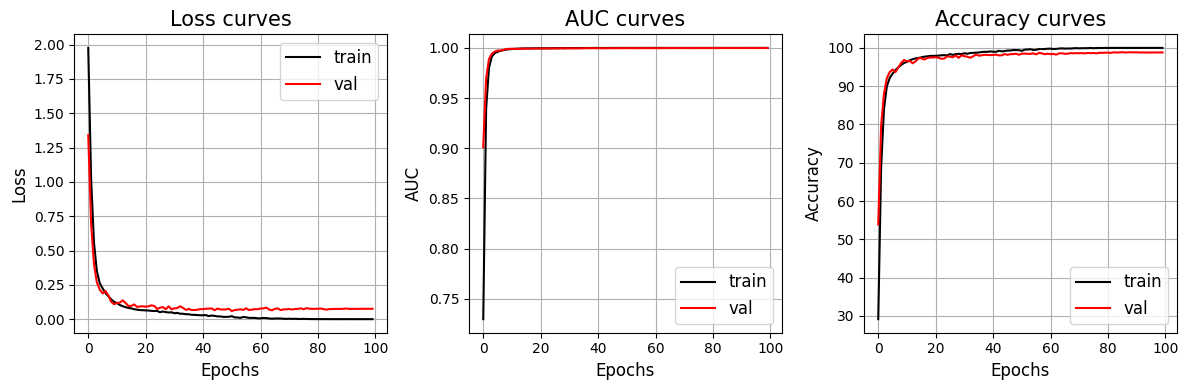

In [13]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_train_loss,"k",label="train")
plt.plot(history_val_loss,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()


# AUC
plt.subplot(1, 3, 2)
plt.plot(history_train_auc,"k",label="train")
plt.plot(history_val_auc,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.title("AUC curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(history_train_acc,"k",label="train")
plt.plot(history_val_acc,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# More commands
plt.tight_layout()
plt.show()

In [14]:
# Final Metrics:
model.load_state_dict(torch.load('ViT_mnist_model.pth'))
def final_evaluation(model, data_loader):
    loss = 0
    correct, total = 0,0
    auc_metric = AUROC(task="multiclass",num_classes=10)
    model.eval()
    auc_metric.reset()
    with torch.inference_mode():
        for batch in data_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            pred = model(x)
            l = loss_fn(pred, y)
            loss += l.detach().cpu().item()
            correct += torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).detach().cpu().item()
            total += len(x)
            auc_metric.update(torch.softmax(pred, dim=1), torch.argmax(y, dim=1))

        loss /= len(data_loader)
        acc = correct / total * 100
        auc = auc_metric.compute().detach().cpu().item()
    return loss, acc, auc

# Final Metrics:
model.load_state_dict(torch.load('ViT_mnist_model.pth'))
train_loss, train_accuracy, train_auc = final_evaluation(model,train_loader)
val_loss, val_accuracy, val_auc= final_evaluation(model,val_loader)
test_loss, test_accuracy, test_auc= final_evaluation(model,test_loader)
clear_output()
print("The final losses and accuracies on the training, validation and test sets are as follows:")
print(f"Train | loss: {train_loss:.5f} | Accuracy: {train_accuracy:.3f}% | AUC: {train_auc:.5f}")
print(f"Val   | loss: {val_loss:.5f}   | Accuracy: {val_accuracy:.3f}%   | AUC: {val_auc:.5f}")
print(f"Test  | loss: {test_loss:.5f}  | Accuracy: {test_accuracy:.3f}%  | AUC: {test_auc:.5f}")

The final losses and accuracies on the training, validation and test sets are as follows:
Train | loss: 0.00001 | Accuracy: 100.000% | AUC: 1.00000
Val   | loss: 0.07388   | Accuracy: 98.875%   | AUC: 0.99986
Test  | loss: 0.05705  | Accuracy: 98.930%  | AUC: 0.99988


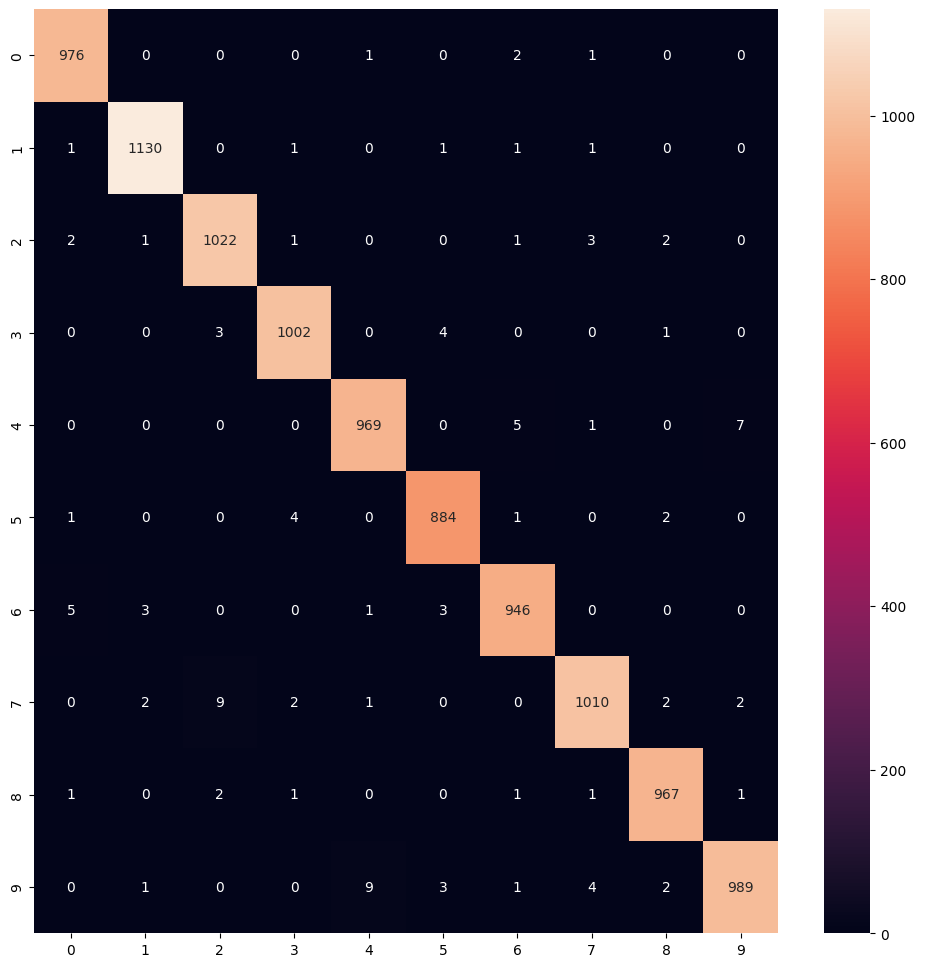

In [15]:
# Plot the confusion matrix for the final evaluation on the test-set:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(y_test, predictions):
    cm = confusion_matrix(np.argmax(np.round(y_test),axis=1), np.argmax(np.round(predictions), axis=1))
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [str(i) for i in range(10)], yticklabels = [str(i) for i in range(10)], fmt="d")
    fig = sns_hmp.get_figure()

pred_list = []
true_list = []
model.eval()
with torch.inference_mode():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        test_pred = model(x)
        pred_list.append(test_pred.cpu().numpy())
        true_list.append(y.cpu().numpy())

pred_list = np.concatenate(pred_list,0)
true_list = np.concatenate(true_list,0)
conf_matrix(true_list, pred_list)

### Results:
 I implemented, from scratch, a vision transfomer and used it on the MNIST dataset. The results obtained on the test set are as follows:
 - Loss: 0.05705  
 - Accuracy: 98.930% 
 - AUC: 0.99988
  
Again, I didn't get a lot of time to tune the hyperparameters owing to my busy schedule. As evident from the difference in the validation and training metrics,the model has overfitted even though the ViT model used here doesn't have a lot of layers. Generally Vision Transformers need a lot of data to have better performance on the test-set than the state of the art CNN models. So this would work better with such problems where we have access to higher amount of data. We ended this up by plotting a confusion matrix to see what classes are being majorly missclassified.

# Recipe for a Quantum Vision Transformer:

I will do the simplest thing possible to realise a QViT. Replace as many classical layers with quantum layers. 
- The convolutional layer in the `PatchEmbedding1D` class can be replaced by a `QConv2D` layer (example implementation).
- The linear layers in the `AttentionHead` class can be replaced with PQCs as proposed by [this](https://arxiv.org/abs/2110.06510) paper. Other ways of computing attention scores can be implemented based on [this](https://arxiv.org/pdf/2205.05625.pdf) paper and [this](https://indico.jlab.org/event/459/papers/11832/files/1318-First_Measurements_With_A_Quantum_Vision_Transformer_A_Naive_Approach_IEEE__CHEP_refereeEdits.pdf) paper.
- The linear projection in the `MultiHeadAttention` block should also be replaced with a PQC.
- The `FullyConnected` blocks must also be replaced by a PQC
- The final classifier layer will then be a quantum classifier.

The problem with this approach is that it will be a little too expensive on the number of qubits. But atleast, the whole architecture is made up of quantum layers only! It is still not a fully quantum realisation of the ViT. It is only almost fully quantum, the reason being that classical way of calculating the attention scores is still being implemented. But nonetheless, this should be tried on a toy dataset atleast for proof of concept. During my time at GSOC24, I would like to certainly give this approach a shot. If possible, a fully quantum version of calculating attention scores should be devised and implemented too. 

Here I briefly describe the way [this](https://indico.jlab.org/event/459/papers/11832/files/1318-First_Measurements_With_A_Quantum_Vision_Transformer_A_Naive_Approach_IEEE__CHEP_refereeEdits.pdf) paper describes the caclulation of Quantum Attention. I plan to be implementing this during the coding period. 

They have described a classical-quantum hybrid approach for realizing quantum self-attention. They advocate for downsizing query (Q) and key (K) values through a classical linear layer, followed by concatenation and activation with the hyperbolic tangent function (tanh). Subsequently, these values are scaled by a factor alpha before being inputted into a Parameterized Quantum Circuit (PQC). Within this circuit, information is encoded using Ry gates, and PennyLane’s strongly entangling Ansatz is applied. The resultant expectation values are then fed into a softmax layer to ascertain attention scores, thus offering a novel quantum method for their computation. Following this, attention scores and the Value vector undergo a similar process of downsizing, concatenation, and activation, culminating in the output of the attention layer. The heads are concatenated, and the resultant output is projected onto appropriate dimensions before being transferred to subsequent QViT layers.

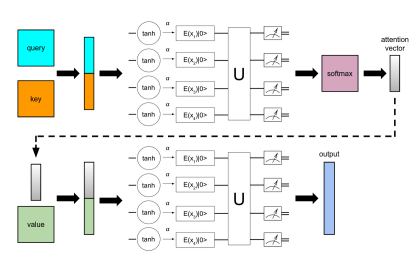 (Image courtesy: [paper](https://indico.jlab.org/event/459/papers/11832/files/1318-First_Measurements_With_A_Quantum_Vision_Transformer_A_Naive_Approach_IEEE__CHEP_refereeEdits.pdf))